# Image recognition: classifying landcover (EuroSAT)


#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

## Introduction

This tutorial shows how to do whole image classification, or image `recognition`, starting from JPEG image files, first leveraging pre-trained weights (transfer learning), then training the same model from scratch, without transfer learning.

We demonstrate the workflow on the [EuroSAT](https://arxiv.org/abs/1709.00029) landcover/use classification dataset, using image augmentation

In this notebook we train 4 different models on the same data to compare training strategies

1. transfer learning (initializing the model with weights learned from another - typically larger - dataset)
2. training from scratch
3. transfer learning with fine-tuning
4. transfer learning for feature extraction, then using a machine learning classifier (logistic regression) on the extracted features

The accuracy of the model improved from ~60% with transfer learning, to 70% by training from scratch, to well over 90% using fine-tuning on a model initialized with transfered weights. Finally, a similar accuracy of more than 90% was acheived by using logistic regression on features extracted by a pre-trained network 

## Setup

We need the latest keras to access`layers.experimental.preprocessing`

In [0]:
!pip install tf-nightly --quiet

     |████████████████████████████████| 523.8MB 34kB/s 
     |████████████████████████████████| 460kB 56.2MB/s 
     |████████████████████████████████| 2.9MB 52.0MB/s 


Import the tensorflow and keras libraries and functions we'll need

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

tf.__version__

'2.3.0-dev20200527'

Import other libraries

In [0]:
import requests, os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression

## Load the data: EuroSAT


The following function allows us to download a file on google drive

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

First, let's download the 106M zip archive of the raw data:

In [0]:
file_id = '1dBfQw66GbggsvnTKQuiiKBy6UqQHdQO-'

destination = 'EuroSAT.zip'
download_file_from_google_drive(file_id, destination)

In this example I have pre-sorted the imagery into train and test splits, by randomly selecting from among the images in each class

Unzip both zipped files (piping output to `tmp.txt` so we don't clutter our screens with lots of output) 

In [0]:
!unzip EuroSAT.zip > tmp.txt

What categories do we have?

In [0]:
!ls EuroSAT

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


Make a new directory `EuroSAT_test`, and rename the `EuroSAT` directory `EuroSAT_train`

In [0]:
!mkdir EuroSAT_test

In [0]:
!mv EuroSAT EuroSAT_train

## Generate a Dataset

Set the batch size (number of images the model trains on at any one time)

In [0]:
batch_size = 16

Get a list of subdirectories as classes

In [0]:
D = []
for k in os.walk('EuroSAT_train'):
  D.append(k)

In [0]:
classes = sorted(D[0][1])
print(classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Use system commands to 
1. create a subdirectory for each class under `test`
2. move a random subset of 1000 images from train to test

In [0]:
for k in classes:
  print("Creating test set for %s" % (k))
  os.system('mkdir EuroSAT_test/'+k)
  os.system('shuf -zn1000 -e ./EuroSAT_train/'+k+'/*.jpg | xargs -0 mv -vt ./EuroSAT_test/'+k+'/')

Creating test set for AnnualCrop
Creating test set for Forest
Creating test set for HerbaceousVegetation
Creating test set for Highway
Creating test set for Industrial
Creating test set for Pasture
Creating test set for PermanentCrop
Creating test set for Residential
Creating test set for River
Creating test set for SeaLake


The following commands count how many images are in the `EuroSAT_train/River` and `EuroSAT_test/River` folders 

In [0]:
!ls EuroSAT_train/River | wc -l

1500


In [0]:
!ls EuroSAT_test/River | wc -l

1000


Get rid of corrupted image files

In [0]:
num_skipped = 0
for folder in ['EuroSAT_test', 'EuroSAT_train']:
  for folder_name in classes:
    folder_path = os.path.join(folder, folder_name)
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      fobj = open(fpath, 'rb')
      if tf.compat.as_bytes('JFIF') not in fobj.peek(10):
          num_skipped += 1
          # Delete corrupted image
          os.system('rm ' + fpath)
  print('Deleted %d images' % num_skipped)

Deleted 0 images
Deleted 1 images


## Augmenting the data

We'll use 224x224 pixel imagery, because that will allow us to use the [MobileNet V2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html) model as a feature extractor, pretrained with weights learned on the [Imagenet](http://www.image-net.org/) dataset

Below we define a separate generator for train and validation/test splits (we'll use the same set for model validation and testing), using the keras `image_dataset_from_directory` function

In [0]:
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_train', seed=2020,
    image_size=image_size, batch_size=batch_size) 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_test',  seed=2020,
    image_size=image_size, batch_size=batch_size)

Found 16873 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Let's plot a few with their labels to visualize the data

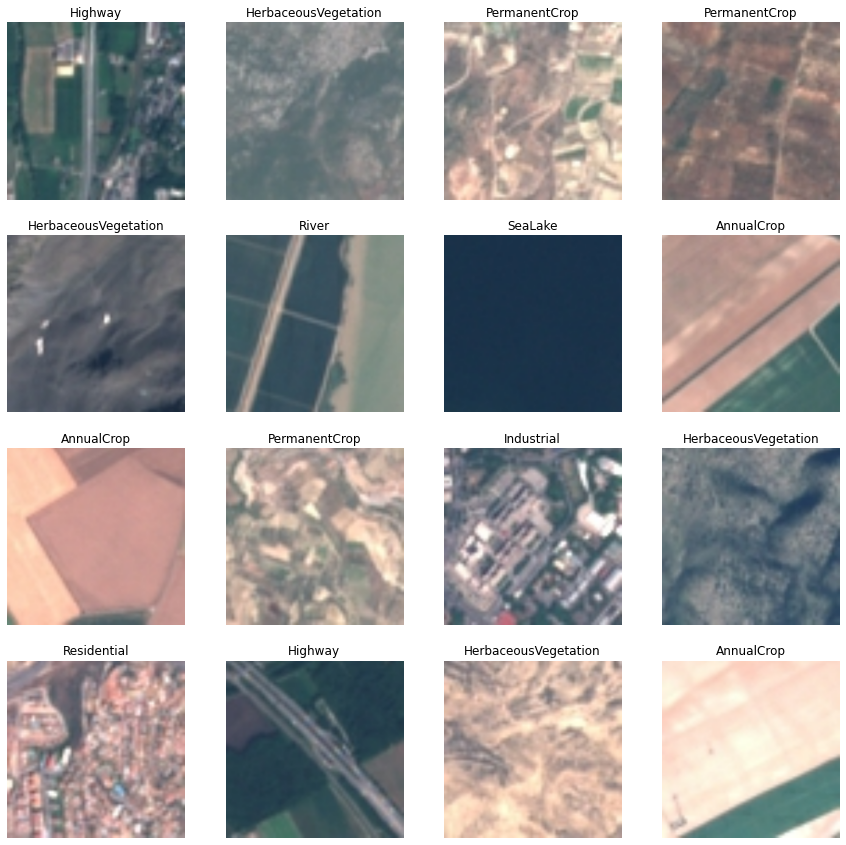

In [0]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[int(labels[i])])
    plt.axis('off')

We'll define a few augmentation transformations: horizontal and vertical flips, and random rotations and zooms up to 30%

In [0]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('vertical'),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomZoom(0.3),
])

Below we see the affects of these random augmentations on one sample image drawn at random

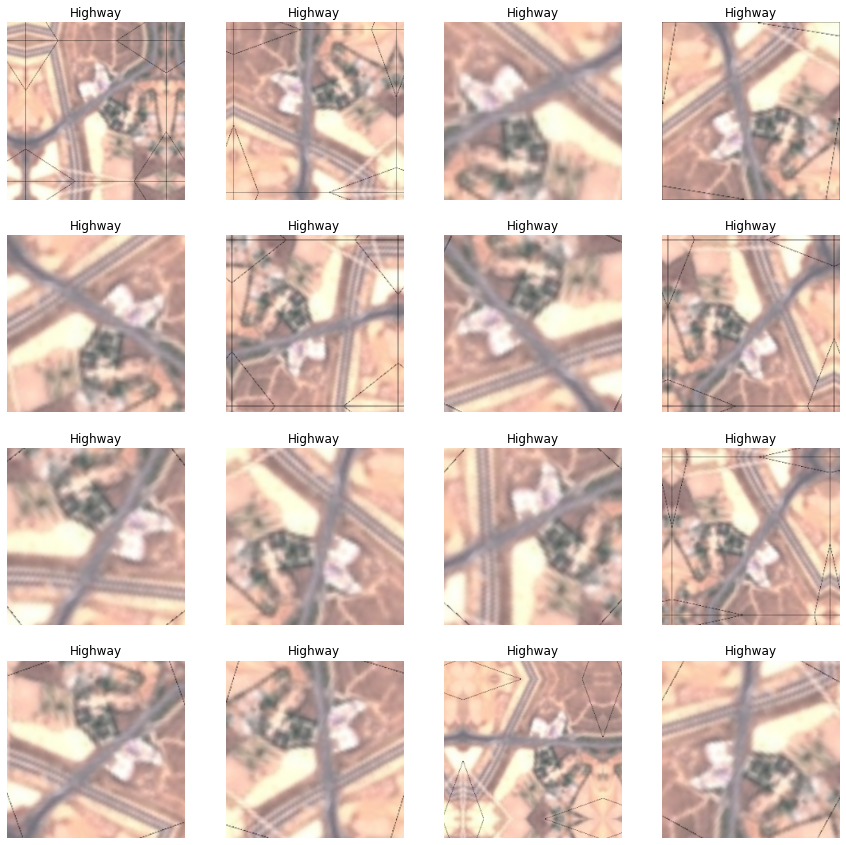

In [0]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((augmented_images[0].numpy()).astype('uint8')) 
    plt.title(classes[int(labels[0])])
    plt.axis('off')

Improve model throughput by using [pre-fetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)

In [0]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

Apply the augmentation to the training set using the `map` and `lambda` commands to apply the augmentations on the fly (i.e. during model training) rather than all in advance

In [0]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Image classification using transfer learning

### Build a model


We'll use one of the 'stock' models provided by `keras.applications` called MobileNetV2

Load the MobileNetV2 model trained on imagenet, but exclude the classification layers, because we want to add our own classification layers so we can retrain the model on our own categories

In [0]:
def transfer_learning_mobilenet_model(num_classes, input_shape, dense_nodes, dropout_rate): 

    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=input_shape)

    EXTRACTOR.trainable = True #use False to leave the feature extractor weights alone

    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    # use global 2d pooling on the extracted feature-stack
    class_head = layers.GlobalAveragePooling2D()(class_head)
    # dense layer to further reduce dimensionality
    class_head = layers.Dense(dense_nodes, activation="relu")(class_head) 
    # add dropout for regularization
    class_head = layers.Dropout(dropout_rate)(class_head)
    # classifying layer 
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model

In [0]:
input_shape = (224, 224) # size of imagery in X and Y dimensions
dense_nodes = 1024 #number of dense nodes for dimensionality reduction
dropout_rate = 0.5 #dropout rate (proportion of neurons to randomly zero out during model training)

Make and plot the model

9412608/9406464 [==============================] - 0s 0us/step


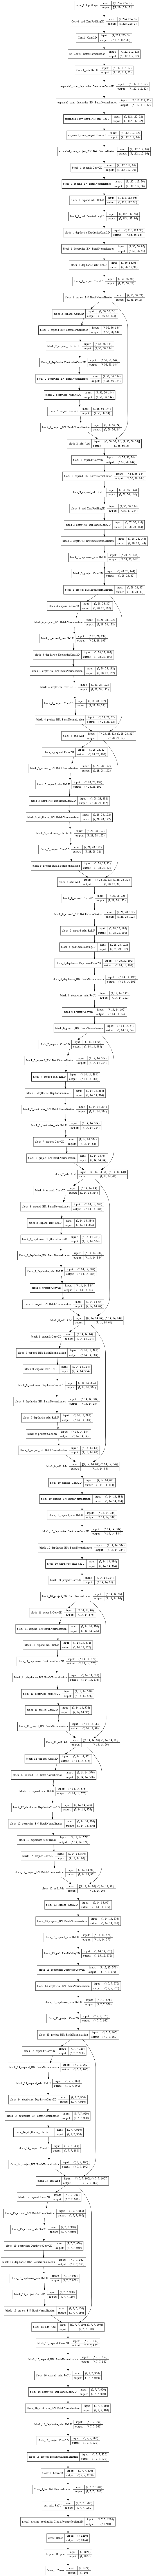

In [0]:
model1 = transfer_learning_mobilenet_model(len(classes), input_shape + (3,), dense_nodes, dropout_rate )
keras.utils.plot_model(model1, show_shapes=True, dpi=64)

### Train the model

Make a filename that the model weights will be stored as

In [0]:
filepath = 'eurosat_mn2_best_weights.h5'

Define hyperparameters

In [0]:
min_lr = 1e-4 #minimum learning rate
patience = 5 #number of training epochs over which validation loss has seen no improevment
# for early stopping and adaptive learning rate
factor = 0.8 #proportional decrease in learning rate
cooldown = 3 #number of training epochs to wait once learning rate reduction is triggered

We'll use early stopping, which will monitor validation loss to trigger cessation of training when validation loss hasn't improved for more than `patience` epochs

Adaptive learning rates are invoked using `ReduceLROnPlateau`

We'll save the best model weights to file using `ModelCheckpoint`

In [0]:
earlystop = EarlyStopping(monitor="val_loss", 
                              mode="min", patience=patience) 

# reduction of learning rate if and when validation scores plateau upon successive epochs
reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                verbose=1, mode='auto', 
                                cooldown=cooldown, min_lr=min_lr)

# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

Compile the model using `sparse_categorical_crossentropy` because we have discrete integer classes

In [0]:
model1.compile(optimizer=keras.optimizers.Adam(min_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Fit the model to the data and keep track of the training `history` so we can plot it afterwards

In [0]:
history = model1.fit(augmented_train_ds, epochs=50, callbacks=callbacks, validation_data=val_ds) 

Epoch 1/50
1055/1055 [==============================] - 258s 245ms/step - loss: 0.7438 - accuracy: 0.7727 - val_loss: 10.0874 - val_accuracy: 0.2799
Epoch 2/50
1055/1055 [==============================] - 253s 239ms/step - loss: 0.4297 - accuracy: 0.8667 - val_loss: 3.3825 - val_accuracy: 0.5093
Epoch 3/50
1055/1055 [==============================] - 253s 240ms/step - loss: 0.3702 - accuracy: 0.8837 - val_loss: 1.1961 - val_accuracy: 0.7244
Epoch 4/50
1055/1055 [==============================] - 250s 237ms/step - loss: 0.3211 - accuracy: 0.9001 - val_loss: 4.2874 - val_accuracy: 0.4097
Epoch 5/50
1055/1055 [==============================] - 251s 238ms/step - loss: 0.3131 - accuracy: 0.9023 - val_loss: 2.2693 - val_accuracy: 0.6798
Epoch 6/50
1055/1055 [==============================] - 251s 238ms/step - loss: 0.2790 - accuracy: 0.9103 - val_loss: 1.2752 - val_accuracy: 0.7490
Epoch 7/50
1055/1055 [==============================] - 252s 239ms/step - loss: 0.2533 - accuracy: 0.9189 - val

Let's check on what variables are containing in `history`

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

How many training epochs did the model use?

In [0]:
n = len(history.history['accuracy'])

Plot the train and validation accuracy and loss training histories

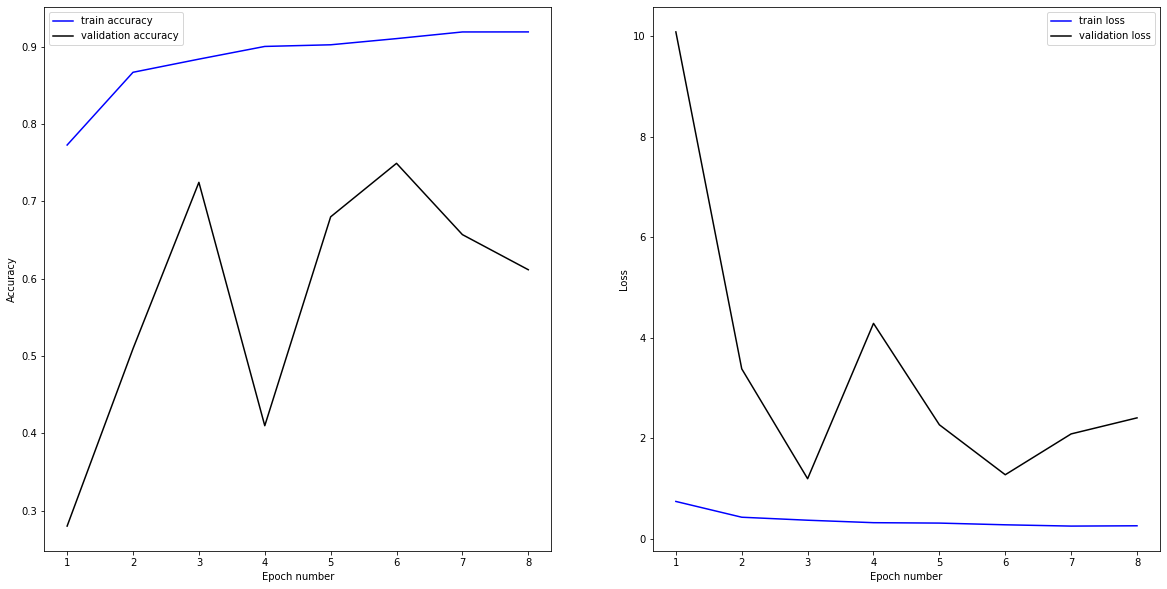

In [0]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(np.arange(1,n+1), history.history['accuracy'], 'b', label='train accuracy')
plt.plot(np.arange(1,n+1), history.history['val_accuracy'], 'k', label='validation accuracy')
plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Accuracy', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(122)
plt.plot(np.arange(1,n+1), history.history['loss'], 'b', label='train loss')
plt.plot(np.arange(1,n+1), history.history['val_loss'], 'k', label='validation loss')
plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

### Run inference on new data

Use the model to estimate the landcover for a sample test image. We load and resize the image to the same as those used during model training. Then `expand_dims` so the image is a 4D tensor. The model `predict` function is used to calculate a likelihood for each class. The `argmax` is used to find the location of the maximum. We use that as our class prediction

(note that Dropout layers are inactive at inference time, so it won't affect our model results)

This image is River.


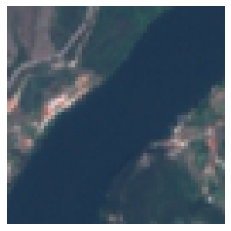

In [0]:
f = glob('EuroSAT_test/River/*.jpg')[0]

img = keras.preprocessing.image.load_img(f, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.imshow(img)
plt.axis('off')

scores = model1.predict(img_array, batch_size=128)
counter = np.argmax(scores[0])
print('This image is %s.' % (sorted(classes)[counter]))

We can use the `model.evaluate()` function to evaluate the average accuracy for the entire test set

In [0]:
scores = model1.evaluate(val_ds)

10000/10000 [==============================] - 59s 6ms/step - loss: 2.4070 - accuracy: 0.6114


Accuracies are in the low 60 percent range. We can probably do better

### Confusion matrix

A confusion matrix is a matrix of correspondences between true and model-estimated classes, broken down per class

In [0]:
# val_files = glob('EuroSAT_test')

Define a new validation generator, this time with no random shuffling (`shuffle=False`) and a batch size of just 1

In [0]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_test',  seed=2020, shuffle=False,
    image_size=image_size, batch_size=1)

Found 10000 files belonging to 10 classes.


Cycle through each image and get the ground truth label

In [0]:
L = []
for _, labels in val_ds:
  L.append(int(labels[0]))

How many examples in each class?

In [0]:
np.bincount(L)

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

Get the model class predictions for each image

In [0]:
preds = model1.predict(val_ds)
pred = np.argmax(preds, axis=1)

Compute the confusion matrix, then normalize the frequencies in each matrix cell by row totals, so each grid element is a proportion of all classifications in that class

In [0]:
cm = confusion_matrix(np.asarray(L), pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

For display purposes, we set all small values (defined as less than 0.1) to 0

In [0]:
thres = 0.1
cm[cm<thres] = 0

Plot and label the confusion matrix. The y-axis are the true labels and the x-axis are the estimated

([<matplotlib.axis.YTick at 0x7fb3fa9d2f60>,
 [Text(0, 0.5, 'AnnualCrop'),
  Text(0, 1.5, 'Forest'),
  Text(0, 2.5, 'HerbaceousVegetation'),
  Text(0, 3.5, 'Highway'),
  Text(0, 4.5, 'Industrial'),
  Text(0, 5.5, 'Pasture'),
  Text(0, 6.5, 'PermanentCrop'),
  Text(0, 7.5, 'Residential'),
  Text(0, 8.5, 'River'),
  Text(0, 9.5, 'SeaLake')])

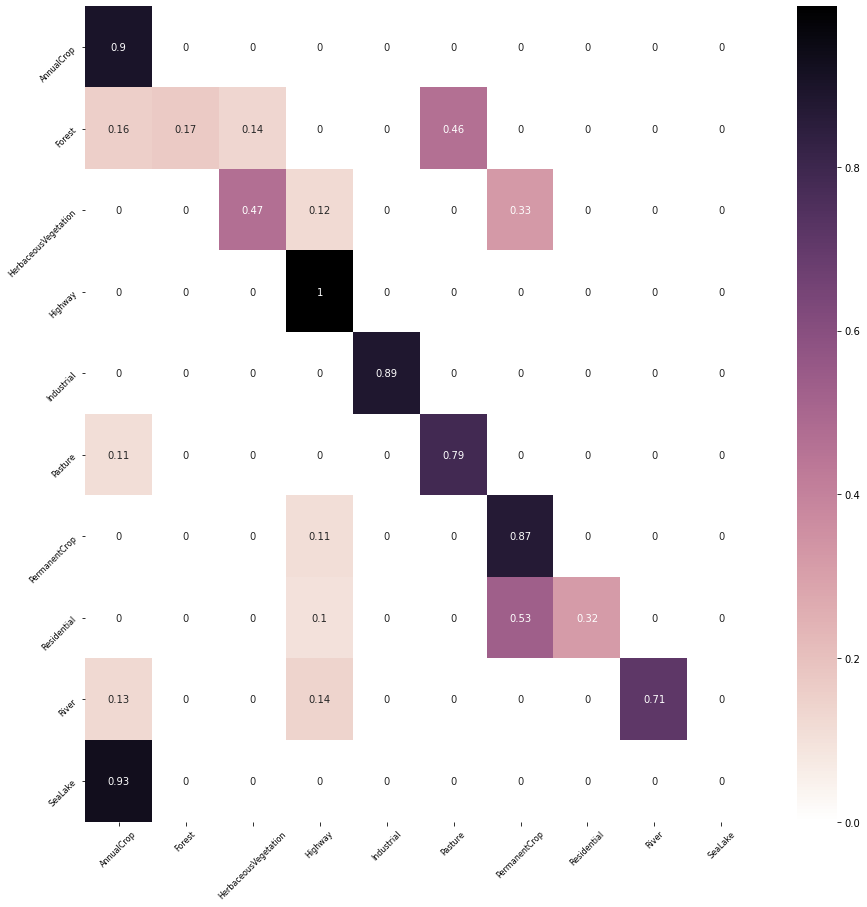

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

The mean true positive score (accuracy) in percent is the mean of the diagonal matrix elements, multipled by 100

In [0]:
print('Mean classification accuracy across %i classes is %.0f percent' % (len(classes), 100*np.mean(np.diag(cm))))

Mean classification accuracy across 10 classes is 61 percent


That is our baseline accuracy, in the low 60s percent

## Building an image classifier from scratch

### Build a model


This time we don't initialize the model with `imagenet` weights

In [0]:
def mobilenet_model(num_classes, input_shape):

    EXTRACTOR = MobileNetV2(include_top=False, input_shape=input_shape)

    # We will set it to both True and False
    EXTRACTOR.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model

make a model

In [0]:
model2 = mobilenet_model(len(classes), input_shape+(3,) )

### Train the model

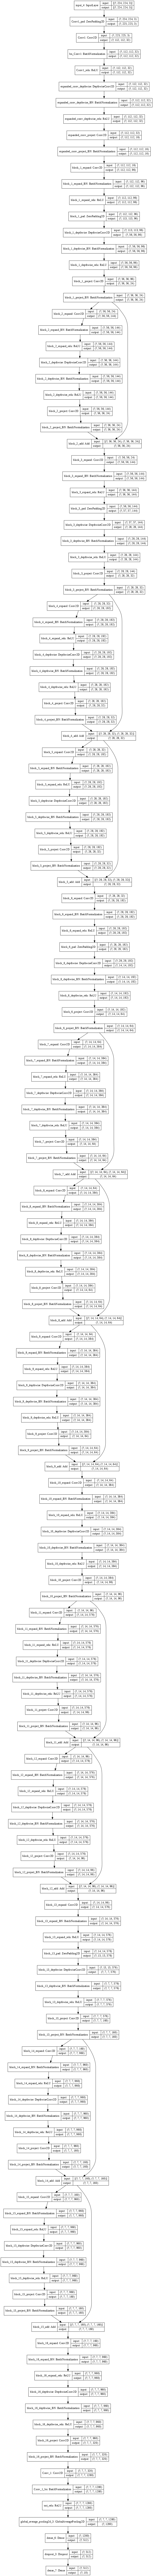

In [0]:
keras.utils.plot_model(model2, show_shapes=True, dpi=64)

In [0]:
filepath = 'eurosat_mn2_scratch_best_weights.h5'
max_epochs = 50

In [0]:
earlystop = EarlyStopping(monitor="val_loss", 
                              mode="min", patience=patience) 

# reduction of learning rate if and when validation scores plateau upon successive epochs
reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                verbose=1, mode='auto', 
                                cooldown=cooldown, min_lr=min_lr)

# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

In [0]:
model2.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history2 = model2.fit(augmented_train_ds, epochs=max_epochs, callbacks=callbacks, validation_data=val_ds) 

Epoch 1/50
1055/1055 [==============================] - 297s 281ms/step - loss: 0.7376 - accuracy: 0.7745 - val_loss: 11.6924 - val_accuracy: 0.1387
Epoch 2/50
1055/1055 [==============================] - 295s 280ms/step - loss: 0.4583 - accuracy: 0.8592 - val_loss: 3.4265 - val_accuracy: 0.4508
Epoch 3/50
1055/1055 [==============================] - 296s 280ms/step - loss: 0.3848 - accuracy: 0.8806 - val_loss: 3.3943 - val_accuracy: 0.5471
Epoch 4/50
1055/1055 [==============================] - 295s 280ms/step - loss: 0.3520 - accuracy: 0.8906 - val_loss: 3.3199 - val_accuracy: 0.5440
Epoch 5/50
1055/1055 [==============================] - 296s 280ms/step - loss: 0.3040 - accuracy: 0.9054 - val_loss: 0.9326 - val_accuracy: 0.7580
Epoch 6/50
1055/1055 [==============================] - 295s 280ms/step - loss: 0.2945 - accuracy: 0.9108 - val_loss: 0.9030 - val_accuracy: 0.7881
Epoch 7/50
1055/1055 [==============================] - 295s 279ms/step - loss: 0.2631 - accuracy: 0.9167 - val

### Run inference on new data


This image is River.


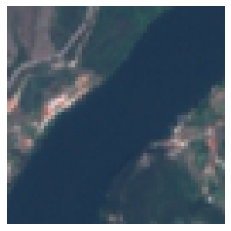

In [0]:
f = glob('EuroSAT_test/River/*.jpg')[0]

img = keras.preprocessing.image.load_img(f, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.imshow(img)
plt.axis('off')

scores = model2.predict(img_array, batch_size=128)
counter = np.argmax(scores[0])
print('This image is %s.' % (sorted(classes)[counter]))

### Confusion matrix

A confusion matrix is a matrix of correspondences between true and model-estimated classes, broken down per class

Define a new validation generator, this time with no random shuffling (`shuffle=False`) and a batch size of just 1

In [0]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_test',  seed=2020, shuffle=False,
    image_size=image_size, batch_size=1)

Found 10000 files belonging to 10 classes.


Cycle through each image and get the ground truth label

In [0]:
L = []
for _, labels in val_ds:
  L.append(int(labels[0]))

Get the model class predictions for each image

In [0]:
preds = model2.predict(val_ds)
pred = np.argmax(preds, axis=1)

Compute the confusion matrix, then normalize the frequencies in each matrix cell by row totals, so each grid element is a proportion of all classifications in that class

In [0]:
cm = confusion_matrix(np.asarray(L), pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

For display purposes, we set all small values (defined as less than 0.1) to 0

In [0]:
thres = 0.1
cm[cm<thres] = 0

Plot and label the confusion matrix. The y-axis are the true labels and the x-axis are the estimated

([<matplotlib.axis.YTick at 0x7fb4dab6a588>,
 [Text(0, 0.5, 'AnnualCrop'),
  Text(0, 1.5, 'Forest'),
  Text(0, 2.5, 'HerbaceousVegetation'),
  Text(0, 3.5, 'Highway'),
  Text(0, 4.5, 'Industrial'),
  Text(0, 5.5, 'Pasture'),
  Text(0, 6.5, 'PermanentCrop'),
  Text(0, 7.5, 'Residential'),
  Text(0, 8.5, 'River'),
  Text(0, 9.5, 'SeaLake')])

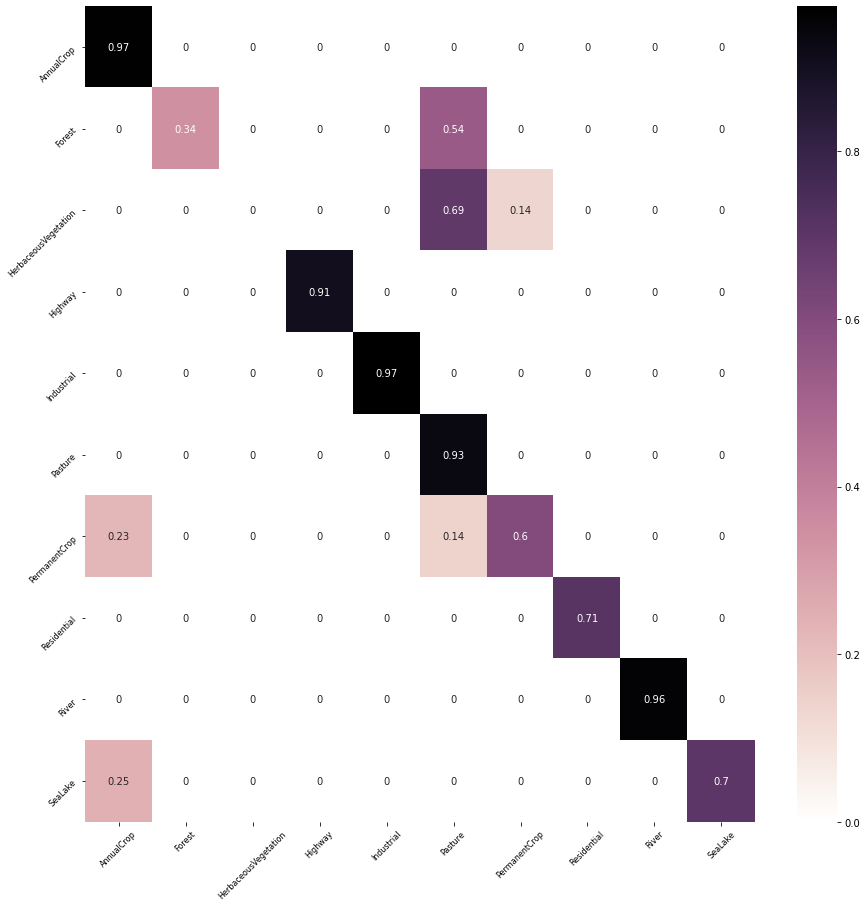

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

In [0]:
print('Mean classification accuracy across %i classes is %.0f percent' % (len(classes), 100*np.mean(np.diag(cm))))

Mean classification accuracy across 10 classes is 71 percent


Our baseline 'transfer learning' accuracy for 10 landcover classes was in the low 60s percent. Training from scratch, we get a score in the low 70s

This is an indication that the model can improve more if we `fine tune` the model layers to the data

## Fine tune model layers

One way to increase performance is to train (or "fine-tune") the weights of the top layers of the pre-trained model (from imagenet) alongside the training of the classifier we added. 

The training process will force the weights to be tuned from generic features extracted from generic imagery to features associated specifically with the specific imagery we want to test on.

The goal of fine-tuning is to adapt the high-level layers that are specialized feature extractors, rather than overwrite the generic learning (handled by the lower layers) that we 'freeze'

In [0]:
def finetune_transfer_learning_mobilenet_model(num_classes, input_shape, dense_nodes, dropout_rate): 

    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=input_shape)

    EXTRACTOR.trainable = True #use False to leave the feature extractor weights alone

    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    # use global 2d pooling on the extracted feature-stack
    class_head = layers.GlobalAveragePooling2D()(class_head)
    # dense layer to further reduce dimensionality
    class_head = layers.Dense(dense_nodes, activation="relu")(class_head) 
    # add dropout for regularization
    class_head = layers.Dropout(dropout_rate)(class_head)
    # classifying layer 
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model

Make a new model

In [0]:
dense_nodes = 512
dropout_rate = 0.5

model3 = finetune_transfer_learning_mobilenet_model(len(classes), input_shape+(3,), dense_nodes, dropout_rate)

print("Number of tunable layers in the base model: ", len(model3.layers))

Number of tunable layers in the base model:  159


Train this model for just a few epochs

In [0]:
model3.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model3.fit(augmented_train_ds, epochs=5, validation_data=val_ds) 

Epoch 1/5
1055/1055 [==============================] - 298s 283ms/step - loss: 0.7528 - accuracy: 0.7706 - val_loss: 5.3835 - val_accuracy: 0.3507
Epoch 2/5
1055/1055 [==============================] - 296s 281ms/step - loss: 0.4669 - accuracy: 0.8544 - val_loss: 2.4526 - val_accuracy: 0.4138
Epoch 3/5
1055/1055 [==============================] - 296s 280ms/step - loss: 0.3707 - accuracy: 0.8867 - val_loss: 2.8412 - val_accuracy: 0.5823
Epoch 4/5
1055/1055 [==============================] - 299s 283ms/step - loss: 0.3374 - accuracy: 0.8944 - val_loss: 3.2043 - val_accuracy: 0.5451
Epoch 5/5
1055/1055 [==============================] - 297s 281ms/step - loss: 0.3118 - accuracy: 0.9032 - val_loss: 2.9144 - val_accuracy: 0.5800


The lowest layers in the model deal with the low-level image features that are somewhat generic to most imagery

The higher level layers deal with dataset-specific image feature structure, pulling out high level features that are specific to this classification task

We freeze the first 50 layers of the model and only train the rest

In [0]:
# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in model3.layers[:fine_tune_at]:
  layer.trainable =  False

We'll fine-tune for up to 50 eochs and train the model again

In [0]:
max_epochs = 50
filepath = 'eurosat_mn2_finetune_best_weights.h5'
min_lr = 1e-4

In [0]:
# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

In [0]:
model3.compile(optimizer=keras.optimizers.Adam(min_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model3.fit(augmented_train_ds, epochs=max_epochs, callbacks=callbacks, validation_data=val_ds) 

Epoch 1/50
1055/1055 [==============================] - 239s 227ms/step - loss: 0.2049 - accuracy: 0.9339 - val_loss: 0.1727 - val_accuracy: 0.9467
Epoch 2/50
1055/1055 [==============================] - 238s 225ms/step - loss: 0.1544 - accuracy: 0.9487 - val_loss: 0.1262 - val_accuracy: 0.9610
Epoch 3/50
1055/1055 [==============================] - 239s 226ms/step - loss: 0.1324 - accuracy: 0.9549 - val_loss: 0.1281 - val_accuracy: 0.9590
Epoch 4/50
1055/1055 [==============================] - 241s 228ms/step - loss: 0.1263 - accuracy: 0.9590 - val_loss: 0.1024 - val_accuracy: 0.9668
Epoch 5/50
1055/1055 [==============================] - 240s 227ms/step - loss: 0.1220 - accuracy: 0.9588 - val_loss: 0.1058 - val_accuracy: 0.9656
Epoch 6/50
1055/1055 [==============================] - 240s 227ms/step - loss: 0.1118 - accuracy: 0.9628 - val_loss: 0.1178 - val_accuracy: 0.9623
Epoch 7/50
1055/1055 [==============================] - 240s 228ms/step - loss: 0.1091 - accuracy: 0.9634 - val_

Get the new test scores with the fine-tuned model

In [0]:
scores = model3.evaluate(val_ds)

10000/10000 [==============================] - 60s 6ms/step - loss: 0.1153 - accuracy: 0.9627


Much better, the validation accuracy is now over 90%

### Confusion matrix

In [0]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_test',  seed=2020, shuffle=False,
    image_size=image_size, batch_size=1)

Found 10000 files belonging to 10 classes.


In [0]:
L = []
for _, labels in val_ds:
  L.append(int(labels[0]))

In [0]:
preds = model3.predict(val_ds)
pred = np.argmax(preds, axis=1)

In [0]:
# plot the confusion matrix
cm = confusion_matrix(np.asarray(L), pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [0]:
thres = 0.1
cm[cm<thres] = 0

([<matplotlib.axis.YTick at 0x7fb4e388b198>,
 [Text(0, 0.5, 'AnnualCrop'),
  Text(0, 1.5, 'Forest'),
  Text(0, 2.5, 'HerbaceousVegetation'),
  Text(0, 3.5, 'Highway'),
  Text(0, 4.5, 'Industrial'),
  Text(0, 5.5, 'Pasture'),
  Text(0, 6.5, 'PermanentCrop'),
  Text(0, 7.5, 'Residential'),
  Text(0, 8.5, 'River'),
  Text(0, 9.5, 'SeaLake')])

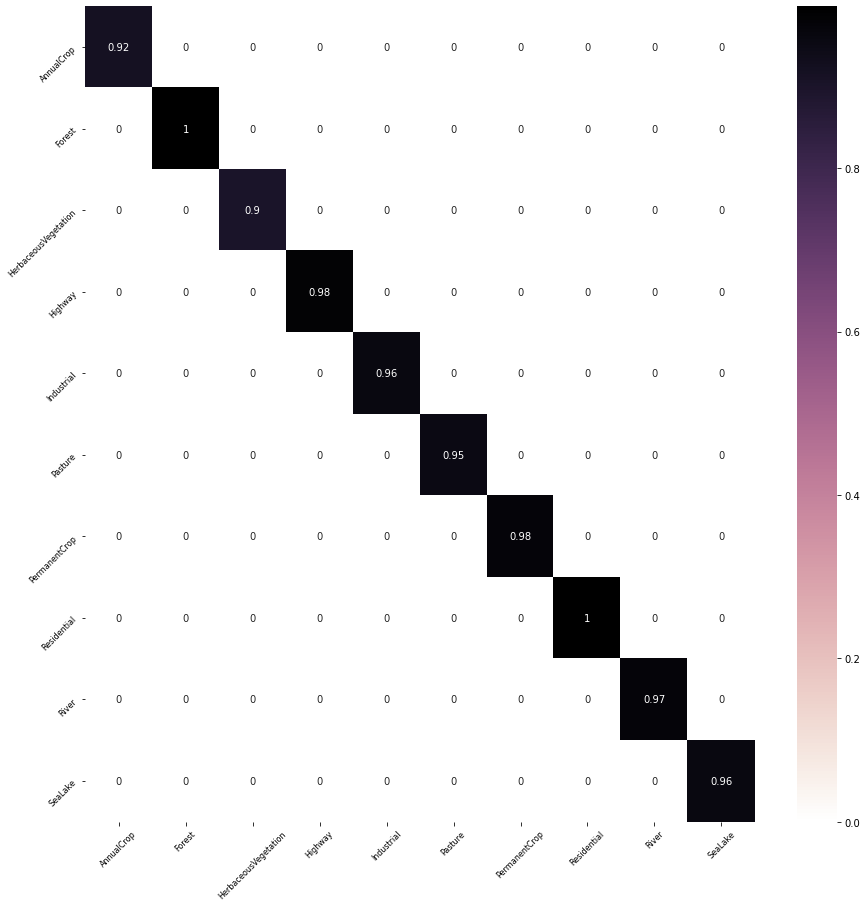

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

In [0]:
print("Average accuracy across %i classes: %.3f" % (len(classes), np.mean(np.diag(cm))))

Average accuracy across 10 classes: 0.963


The accuracy of the model improved from ~60% with transfer learning, to 70% by training from scratch, to well over 90% using fine-tuning on a model initialized with transfered weights

### Semi-supervised image classification using a pre-trained deep learning model

We see what classification accuracy we might achieve using a deep learning model with pre-trained weights without any additional training. This is a form of semi-supervised training, leverage weights from another dataset and labels from this

We use a deep learning model to extract features, combined with a classical ML model for image classification

In [0]:
D = []
for k in os.walk('EuroSAT_train'):
  D.append(k)

In [0]:
train_files = [d for d in D[1][2] if 'jpg' in d]

In [0]:
len(train_files)

1500

In [0]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_train', seed=2020,
    image_size=image_size, batch_size=len(train_files)) 

Found 16873 files belonging to 10 classes.


In [0]:
# variables to hold features and labels
features = []
labels   = []

for i, l in train_ds.take(1):
  for k in range(len(i)):
      im = tf.expand_dims(i[k].numpy().astype('uint8'), 0)  # Create batch axis
      f = model3.predict(im).flatten()
      features.append(f)
      labels.append(int(l[k]))

In [0]:
trainData = np.array(features)
trainLabels = np.array(labels)

In [0]:
D = []
for k in os.walk('EuroSAT_test'):
  D.append(k)

In [0]:
test_files = [d for d in D[1][2] if 'jpg' in d]

In [0]:
len(test_files)

1000

In [0]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'EuroSAT_test', seed=2020,
    image_size=image_size, batch_size=len(test_files)) 

Found 10000 files belonging to 10 classes.


In [0]:
# variables to hold features and labels
features = []
labels   = []

for i, l in test_ds.take(1):
  for k in range(len(i)):
      im = tf.expand_dims(i[k].numpy().astype('uint8'), 0)  # Create batch axis
      f = model3.predict(im).flatten()
      features.append(f)
      labels.append(int(l[k]))

In [0]:
testData = np.array(features)
testLabels = np.array(labels)

In [0]:
classifier = LogisticRegression(C=0.5, dual=False, random_state=2020)
classifier.fit(trainData, trainLabels)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# evaluate the model of test data
preds = classifier.predict(testData)

In [0]:
cm = confusion_matrix(testLabels, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

([<matplotlib.axis.YTick at 0x7fb4e39c62b0>,
 [Text(0, 0.5, 'AnnualCrop'),
  Text(0, 1.5, 'Forest'),
  Text(0, 2.5, 'HerbaceousVegetation'),
  Text(0, 3.5, 'Highway'),
  Text(0, 4.5, 'Industrial'),
  Text(0, 5.5, 'Pasture'),
  Text(0, 6.5, 'PermanentCrop'),
  Text(0, 7.5, 'Residential'),
  Text(0, 8.5, 'River'),
  Text(0, 9.5, 'SeaLake')])

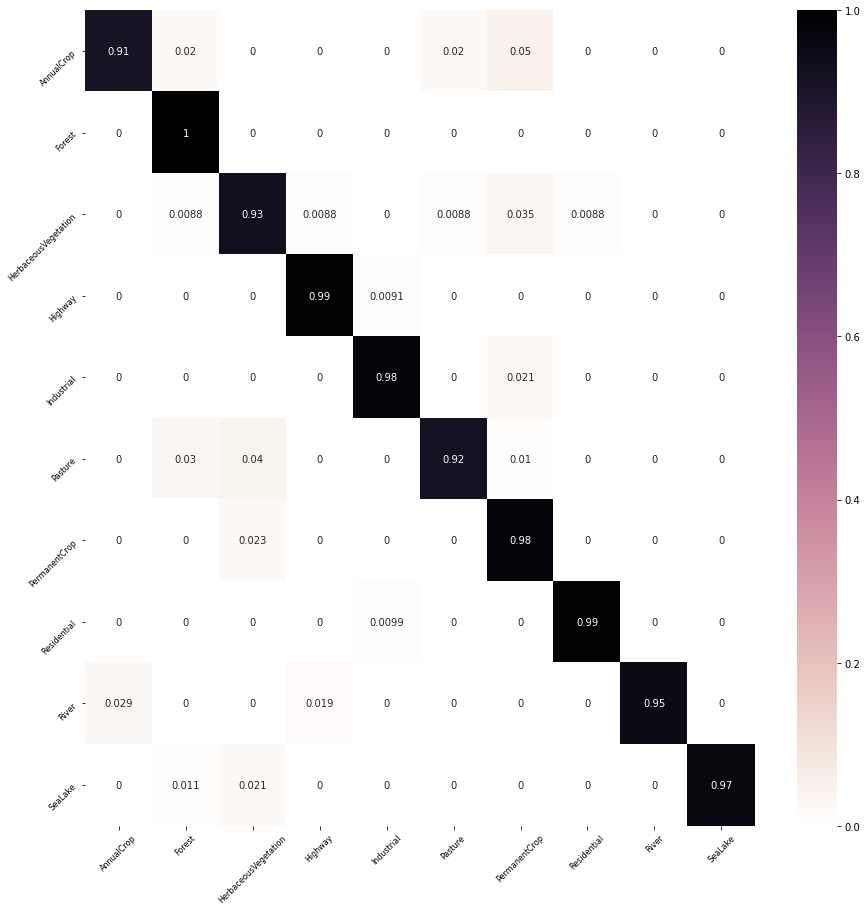

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

In [0]:
print("Average accuracy across %i classes: %.3f" % (len(classes), np.mean(np.diag(cm))))

Average accuracy across 10 classes: 0.962
